In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn.gaussian_process as gp

# 1 Dimensional

In [2]:
def plot_1d(X_te, y_te, std, X_tr, y_tr, n):
    plt.figure()
    fig, (ax1, ax2) = plt.subplots(2, sharex=True)
    ax1.set_title("Estimate and Uncertainty")
    ax1.fill_between(X_te.reshape(-1), y_te-std, y_te+std, alpha=0.2, color="b")
    ax1.fill_between(X_te.reshape(-1), y_te-2*std, y_te+2*std, alpha=0.1, color="b")
    ax1.fill_between(X_te.reshape(-1), y_te-3*std, y_te+3*std, alpha=0.05, color="b")
    ax1.plot(X_te, y_te)
    ax1.scatter(X_tr, y_tr)
    
    ax2.set_title("Uncertainty Map")
    ax2.plot(X_te, std)
    fig.savefig("gaussianprocess/1d_fig{:02d}.png".format(n))
    plt.close()

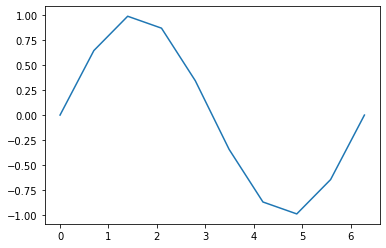

In [3]:
kernel = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(10.0, (1e-3, 1e3))
model = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1, normalize_y=True)

def f(x):
    return np.sin(x)

X_tr = np.linspace(0, 2*np.pi, 10).reshape(-1,1)
y_tr = f(X_tr)

X_te = np.linspace(0, 2*np.pi, 15).reshape(-1,1)

plt.figure()
plt.plot(X_tr, y_tr)

In [4]:
for i in range(1, len(X_tr)):
    model.fit(X_tr[:i], y_tr[:i]) # refits each time
    params = model.kernel_.get_params()

    y_te, std = model.predict(X_te, return_std=True)
    plot_1d(X_te, y_te, std, X_tr[:i], y_tr[:i], i)

/home/enko/.local/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

# 2 Dimensional

In [5]:
def plot_2d(X_te, Y_te, Z_te, std, X_tr, Y_tr, Z_tr, n):
    fig = plt.figure(figsize=plt.figaspect(0.5))


    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax1.set_title("Estimate and Uncertainty")
    ax1.plot_surface(X_te,Y_te,Z_te, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
    ax1.plot_surface(X_te,Y_te,Z_te+abs(std), rstride=1, cstride=1, alpha=0.5,
                cmap='binary', edgecolor='none')
    ax1.plot_surface(X_te,Y_te,Z_te-abs(std), rstride=1, cstride=1, alpha=0.5,
                cmap='binary', edgecolor='none')
    ax1.scatter3D(X_tr, Y_tr, Z_tr)

    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.set_title("Uncertainty Map")
    ax2.plot_surface(X_te, Y_te, std)
    fig.savefig("gaussianprocess/2d_fig{:02d}.png".format(n))
    plt.close()
    

In [6]:
kernel = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(10.0, (1e-3, 1e3))
model = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1, normalize_y=True)
def f(x):
    return np.sin(x[:,0])*np.sin(x[:,1])  
def g(x,y):
    return np.sin(x)*np.sin(y)

(100, 2)
True
(100,)


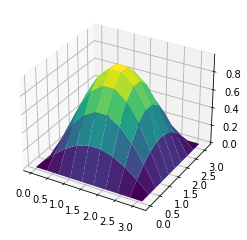

In [7]:
_X = np.linspace(0, np.pi, 10)
X, Y = np.meshgrid(_X, _X)
X_tr = np.column_stack([X.ravel(), Y.ravel()])
print(X_tr.shape)

y_tr = f(X_tr)
Z = g(X, Y)
y_tr = Z.ravel()
print((Z == y_tr.reshape(X.shape)).all())
print(y_tr.shape)

fig = plt.figure()
ax = plt.axes(projection='3d')
# ax.contour3D(X,Y,Z,50)
ax.plot_surface(X,Y,Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')


__X = np.linspace(0, 2*np.pi, 15)
X, Y = np.meshgrid(__X, __X)
X_te = np.column_stack([X.ravel(), Y.ravel()])

In [8]:
for i in range(1, len(_X)):
    _X_tr, _Y_tr = np.meshgrid(_X[:i], _X[:i])
    X_tr = np.column_stack([_X_tr.ravel(), _Y_tr.ravel()])
    Z_tr = g(_X_tr, _Y_tr)
    y_tr = Z_tr.ravel()
    
    model.fit(X_tr, y_tr)
    y_te, std = model.predict(X_te, return_std=True)
    Z_te = y_te.reshape(X.shape)
    std = std.reshape(X.shape)
    plot_2d(X, Y, Z_te, std, _X_tr, _Y_tr, Z_tr, i)

/home/enko/.local/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


# Non-Euclidean


In [9]:
%matplotlib notebook

In [10]:
# Custom Kernel: RBF with different distance metric
def _check_length_scale(X, length_scale):
    length_scale = np.squeeze(length_scale).astype(float)
    if np.ndim(length_scale) > 1:
        raise ValueError("length_scale cannot be of dimension greater than 1")
    if np.ndim(length_scale) == 1 and X.shape[1] != length_scale.shape[0]:
        raise ValueError(
            "Anisotropic kernel must have the same number of "
            "dimensions as data (%d!=%d)" % (length_scale.shape[0], X.shape[1])
        )
    return length_scale

from scipy.spatial.distance import pdist, cdist, squareform

class CustomRBF(gp.kernels.RBF):
    """Radial-basis function kernel (aka squared-exponential kernel).
    The RBF kernel is a stationary kernel. It is also known as the
    "squared exponential" kernel. It is parameterized by a length-scale
    parameter length_scale>0, which can either be a scalar (isotropic variant
    of the kernel) or a vector with the same number of dimensions as the inputs
    X (anisotropic variant of the kernel). The kernel is given by:
    k(x_i, x_j) = exp(-1 / 2 d(x_i / length_scale, x_j / length_scale)^2)
    This kernel is infinitely differentiable, which implies that GPs with this
    kernel as covariance function have mean square derivatives of all orders,
    and are thus very smooth.
    .. versionadded:: 0.18
    Parameters
    -----------
    length_scale : float or array with shape (n_features,), default: 1.0
        The length scale of the kernel. If a float, an isotropic kernel is
        used. If an array, an anisotropic kernel is used where each dimension
        of l defines the length-scale of the respective feature dimension.
    length_scale_bounds : pair of floats >= 0, default: (1e-5, 1e5)
        The lower and upper bound on length_scale
    """
    def __init__(self, distance_metric='sqeuclidean', length_scale=1.0, length_scale_bounds=(1e-5, 1e5)):
        super().__init__(length_scale, length_scale_bounds)
        self.distance_metric = distance_metric

    def __call__(self, X, Y=None, eval_gradient=False):
        """Return the kernel k(X, Y) and optionally its gradient.
        Parameters
        ----------
        X : array, shape (n_samples_X, n_features)
            Left argument of the returned kernel k(X, Y)
        Y : array, shape (n_samples_Y, n_features), (optional, default=None)
            Right argument of the returned kernel k(X, Y). If None, k(X, X)
            if evaluated instead.
        eval_gradient : bool (optional, default=False)
            Determines whether the gradient with respect to the kernel
            hyperparameter is determined. Only supported when Y is None.
        Returns
        -------
        K : array, shape (n_samples_X, n_samples_Y)
            Kernel k(X, Y)
        K_gradient : array (opt.), shape (n_samples_X, n_samples_X, n_dims)
            The gradient of the kernel k(X, X) with respect to the
            hyperparameter of the kernel. Only returned when eval_gradient
            is True.
        """
        X = np.atleast_2d(X)
        length_scale = _check_length_scale(X, self.length_scale)
        if Y is None:
            dists = pdist(X / length_scale, metric=self.distance_metric)
            K = np.exp(-.5 * dists)
            # convert from upper-triangular matrix to square matrix
            K = squareform(K)
            np.fill_diagonal(K, 1)
        else:
            if eval_gradient:
                raise ValueError(
                    "Gradient can only be evaluated when Y is None.")
            dists = cdist(X / length_scale, Y / length_scale,
                          metric=self.distance_metric)
            K = np.exp(-.5 * dists)

        if eval_gradient:
            if self.hyperparameter_length_scale.fixed:
                # Hyperparameter l kept fixed
                return K, np.empty((X.shape[0], X.shape[0], 0))
            elif not self.anisotropic or length_scale.shape[0] == 1:
                K_gradient = \
                    (K * squareform(dists))[:, :, np.newaxis]
                return K, K_gradient
            elif self.anisotropic:
                # We need to recompute the pairwise dimension-wise distances
                K_gradient = (X[:, np.newaxis, :] - X[np.newaxis, :, :]) ** 2 \
                    / (length_scale ** 2)
                K_gradient *= K[..., np.newaxis]
                return K, K_gradient
        else:
            return K
        
        
def plot_noneuclidean(noneuclidean, X_te, Y_te, Z_te, stds, X_tr, Y_tr, Z_tr,n):
    assert len(X_te) == len(Y_te) and len(Y_te) == len(Z_te) and len(Z_te) == len(stds)
    fig = plt.figure(figsize=plt.figaspect(0.5))

    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax1.set_title("Estimate and Uncertainty")
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.set_title("Uncertainty Map")
    
    vmax = max([np.max(Z) for Z in Z_te])
    vmin = min([np.min(Z) for Z in Z_te])
    for i in range(len(X_te)):
        ax1.plot_surface(X_te[i],Y_te[i],Z_te[i], rstride=1, cstride=1,
                    cmap='viridis', edgecolor='none', vmax=vmax, vmin=vmin)
        ax1.plot_surface(X_te[i],Y_te[i],Z_te[i]+abs(stds[i]), rstride=1, cstride=1, alpha=0.5,
                    cmap='binary', edgecolor='none', vmax=vmax, vmin=vmin)
        ax1.plot_surface(X_te[i],Y_te[i],Z_te[i]-abs(stds[i]), rstride=1, cstride=1, alpha=0.5,
                    cmap='binary', edgecolor='none', vmax=vmax, vmin=vmin)
        ax2.plot_surface(X_te[i], Y_te[i], stds[i], cmap='viridis', 
                         vmax=max([np.max(std) for std in stds]), vmin=min([np.min(std) for std in stds]))
    ax1.scatter3D(X_tr, Y_tr, Z_tr)

   
    fig.savefig("gaussianprocess/"+noneuclidean+"_fig{:02d}.png".format(n))
    plt.close()

def plot_on_noneuclidean(noneuclidean, f, X_tests, Y_tests, Z_tests, stds, X_tr, Y_tr, Z_tr, n):
    """
    f(x,y) = point in 3d space
    plots on surface by using color to denote value
    
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib import cm
    import matplotlib.pyplot as plt
    import numpy as np

    fig = plt.figure()
    ax = fig.gca(projection='3d')
    X = np.arange(-5, 5, .25)
    Y = np.arange(-5, 5, .25)
    X, Y = np.meshgrid(X, Y)
    R = np.sqrt(X**2 + Y**2)
    Z = np.sin(R)
    Gx, Gy = np.gradient(Z) # gradients with respect to x and y
    G = (Gx**2+Gy**2)**.5  # gradient magnitude
    N = G/G.max()  # normalize 0..1
    surf = ax.plot_surface(
        X, Y, Z, rstride=1, cstride=1,
        facecolors=cm.jet(N),
        linewidth=0, antialiased=False, shade=False)
    plt.show()
    """
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    
    vmax = max(max([np.max(Z) for Z in Z_tests]), np.max(Z_tr))
    vmin = min(min([np.min(Z) for Z in Z_tests]), np.min(Z_tr))
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    
    train_3d_X, train_3d_Y, train_3d_Z = f(X_tr, Y_tr)
    ax.scatter3D(train_3d_X, train_3d_Y, train_3d_Z, c=Z_tr, vmax=vmax, vmin=vmin)
    for i in range(len(X_tests)): 
        X_te = X_tests[i]
        Y_te = Y_tests[i]
        Z_te = Z_tests[i] - vmin
        test_3d_X, test_3d_Y, test_3d_Z = f(X_te, Y_te)
        
        ax.plot_surface(
            test_3d_X, test_3d_Y, test_3d_Z, rstride=1, cstride=1,
            facecolors=cm.viridis(norm(Z_te)), vmax=vmax, vmin=vmin,
            linewidth=0, antialiased=False, shade=False
        )

def convert_3d(f):
    def result(X, Y):
        Xr = X.ravel()
        Yr = Y.ravel()
        assert len(Xr) == len(Yr)
        temp = np.array([f((Xr[i], Yr[i])) for i in range(len(Xr))]).reshape(*X.shape, 3)
        return temp[..., 0], temp[..., 1], temp[..., 2]
    return result

# plot_on_noneuclidean("box", convert_3d(lambda x: transformation(identify_which_face(x), x)), Xs, Ys, Zs, stds, X_tr[:,0], X_tr[:,1], Z_tr, 0)

<IPython.core.display.Javascript object>


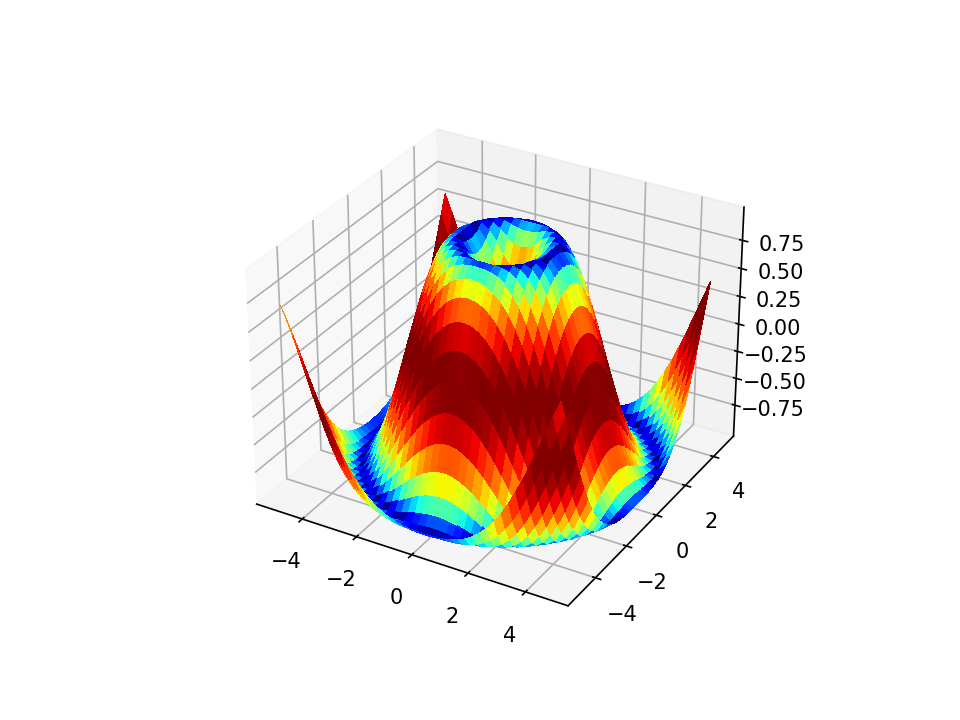

X: (40, 40)
Y: (40, 40)
Z: (40, 40)
N: (40, 40)


In [11]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')
X = np.arange(-5, 5, .25)
Y = np.arange(-5, 5, .25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)
Gx, Gy = np.gradient(Z) # gradients with respect to x and y
G = (Gx**2+Gy**2)**.5  # gradient magnitude
N = G/G.max()  # normalize 0..1
surf = ax.plot_surface(
    X, Y, Z, rstride=1, cstride=1,
    facecolors=cm.jet(N),
    linewidth=0, antialiased=False, shade=False)
plt.show()
print("X:", X.shape)
print("Y:", Y.shape)
print("Z:", Z.shape)
print("N:", N.shape)

## Case Study: Cube

2D representation unfolded

1
2
3
4
5
6


<IPython.core.display.Javascript object>


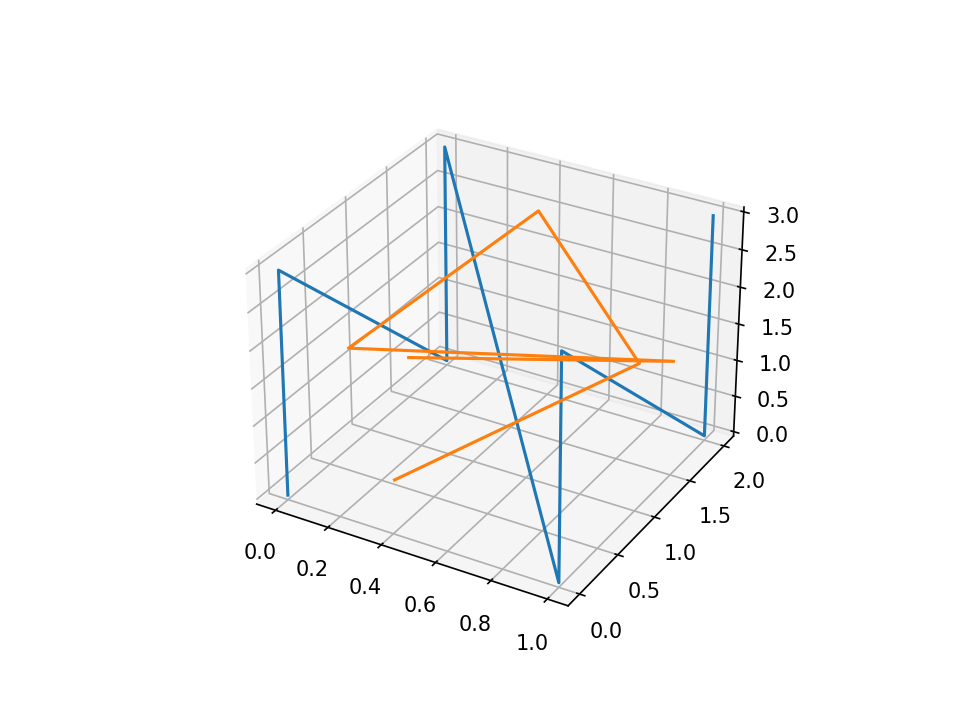

[[0.25 0.5  0.  ]
 [0.75 2.   0.75]
 [0.5  1.5  3.  ]
 [0.25 0.   2.25]
 [1.   1.5  1.5 ]
 [0.   1.5  0.5 ]]


In [12]:
"""
    __4
 __|__|__
|__|__|__|536
   |__|2
   |__|1
(0,0,0)
"""
def create_cube_distance(lenX, lenY, lenZ):
    eps = 1e-10
    def identify_which_face(point):
        x,y = point
        if x > lenX:
            return 6
        elif x < 0:
            return 5
        elif y > lenY+lenZ+lenY:
            return 4
        elif y > lenY+lenZ:
            return 3
        elif y > lenY:
            return 2
        else:
            return 1
        
    def transformation(faceid, point):
        x,y = point
        transform = None
        if faceid == 1:
            transform = (x,y,0)
        elif faceid == 2:
            y = y - lenY
            transform = (x, lenY, y)
        elif faceid == 3:
            y = y - lenY - lenZ
            transform = (x, lenY-y, lenZ)
        elif faceid == 4:
            y = y - lenY - lenZ - lenY
            transform = (x, 0, lenZ-y)
        elif faceid == 5:
            x = x + lenZ
            y = y - lenY - lenZ
            transform = (lenX, lenY-y, x)
        else:
            x = x - lenX
            y = y - lenY - lenZ
            transform = (0, lenY-y, x)
        return np.array(transform)
    
    def cube_distance(point1, point2):
        p1 = transformation(identify_which_face(point1), point1)
        p2 = transformation(identify_which_face(point2), point2)
        return np.linalg.norm(p1 - p2)
    
    return identify_which_face, transformation, cube_distance

lenX, lenY, lenZ = 1, 2, 3
identify_which_face, transformation, cube_distance = create_cube_distance(lenX, lenY, lenZ)
cube_vertices = np.array([(x,y,z) for x in [0,lenX] for y in [0,lenY] for z in [0,lenZ]])
cube_points = [(0.25, 0.5), (0.75, 2+0.75), (0.5, 5+0.5), (0.25, 7+0.75), (-1.5, 5+0.5), (1.5, 5+0.5)]
for p in cube_points:
    print(identify_which_face(p))
on_cube_points = np.array([transformation(identify_which_face(p), p) for p in cube_points])

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(cube_vertices[:,0], cube_vertices[:,1], cube_vertices[:,2])
ax.plot3D(on_cube_points[:,0], on_cube_points[:,1], on_cube_points[:,2])
print(on_cube_points)

In [13]:
# cube_kernel = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * CustomRBF(cube_distance, 10.0, (1e-3, 1e3))
# model = gp.GaussianProcessRegressor(kernel=cube_kernel, n_restarts_optimizer=10, alpha=0.1, normalize_y=True)

# outline = np.array([(0, lenY), (lenX, lenY), (lenX, 0), (0,0), (0, lenY), (0, 2*lenY+2*lenZ), (lenX, 2*lenY+2*lenZ),
#                     (lenX, lenY+lenZ), (lenX+lenZ, lenY+lenZ), (lenX+lenZ, 2*lenY+lenZ), (-lenZ, 2*lenY+lenZ),
#                     (-lenZ, lenY+lenZ), (lenX, lenY+lenZ), (lenX, lenY)])
# plt.figure()
# plt.plot(outline[:,0],outline[:,1])


# wings_X, wings_Y = np.meshgrid(np.linspace(0+lenZ/20, lenZ-lenZ/20, 10), np.linspace(0+lenY/20, lenY-lenY/20, 10))
# wings_tr = np.column_stack([wings_X.ravel(), wings_Y.ravel()])
 
# vert_X, vert_Y = np.meshgrid(np.linspace(0+lenX/20, lenX-lenX/20, 10), np.linspace(0+(lenY+lenZ)/20, 2*lenY+2*lenZ-(lenY+lenZ)/20, 4*10))
# vert_tr = np.column_stack([vert_X.ravel(), vert_Y.ravel()])

# def f(data):
#     return np.array([min(np.linalg.norm(np.array(x)), np.linalg.norm(np.array(x)-np.array([lenX,lenY]))) for x in data])
# def g(x,y):
#     raise NotYetImplemented
#     return np.sin(x)*np.sin(y)
# yw5_tr = f(wings_tr + np.array([-lenZ, lenY+lenZ]))
# yw6_tr = f(wings_tr + np.array([lenX, lenY+lenZ]))
# yv_tr = f(vert_tr)


# _wings_X, _wings_Y = np.meshgrid(np.linspace(0+lenZ/10, lenZ-lenZ/10, 5), np.linspace(0+lenY/10, lenY-lenY/10, 5))
# wings_te = np.column_stack([_wings_X.ravel(), _wings_Y.ravel()])
# _vert_X, _vert_Y = np.meshgrid(np.linspace(0+lenX/10, lenX-lenX/10, 5), np.linspace(0+(lenY+lenZ)/10, 2*lenY+2*lenZ-(lenY+lenZ)/10, 4*5))
# vert_te = np.column_stack([_vert_X.ravel(), _vert_Y.ravel()])

# wings_limit = 10
# vert_limit = 40
# X_tr = np.vstack([wings_tr[:wings_limit]+np.array([[-lenZ, lenY+lenZ]]), wings_tr[:wings_limit]+np.array([lenX, lenY+lenZ]), vert_tr[:vert_limit]])
# y_tr = np.vstack([yw5_tr[:wings_limit].reshape(-1,1), yw6_tr[:wings_limit].reshape(-1,1), yv_tr[:vert_limit].reshape(-1,1)])
# Z_tr = y_tr.reshape(X_tr.shape[0],-1)
# #X_te = np.vstack([wings_te+np.array([-lenZ, lenY+lenZ]), wings_te+np.array([lenX, lenY+lenZ]), vert_te])

# model.fit(X_tr, y_tr)

# Xs = []
# Ys = []
# Zs = []
# stds = []

# for X_te, X, Y in [(vert_te, _vert_X, _vert_Y),
#                    (wings_te+np.array([[-lenZ, lenY+lenZ]]), _wings_X-lenZ, _wings_Y+lenY+lenZ),
#                    (wings_te+np.array([lenX, lenY+lenZ]),    _wings_X+lenX, _wings_Y+lenY+lenZ)]:
#     y_te, std = model.predict(X_te, return_std=True)
#     Z_te = y_te.reshape(X.shape)
#     std = std.reshape(X.shape)
    
#     Xs.append(X)
#     Ys.append(Y)
#     Zs.append(Z_te)
#     stds.append(std)
    
# plot_noneuclidean("box", Xs, Ys, Zs, stds, X_tr[:,0], X_tr[:,1], Z_tr, 0)

3 dimensional directly?

In [14]:
def cube_point_cloud(density, faces=False):
    side_x, side_y = np.meshgrid(np.linspace(0, 1, density), np.linspace(0, 1, density))
    side_x = side_x.ravel()
    side_y = side_y.ravel()
    
    if faces:
        f1 = side_x, side_y, [0]*density**2
        f2 = side_x, [1]*density**2, side_y
        f3 = side_x, side_y, [1]*density**2
        f4 = side_x, [0]*density**2, side_y
        f5 = [0]*density**2, side_y, side_x
        f6 = [1]*density**2, side_y, side_x
        return [f1,f2,f3,f4,f5,f6]
    else:
        x = np.hstack([side_x]*4+[0]*density*density+[1]*density*density)
        y = np.hstack([side_y]+[1]*density*density+[side_y]+[0]*density*density+[side_y]*2)
        z = np.hstack([0]*density*density+[side_y]+[1]*density*density+[side_y]+[side_x]*2)
        return x,y,z
    
def measurement(data):
    return np.max(data, axis=1)

In [ ]:
import pyvista as pv

kernel = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(10.0, (1e-3, 1e3))
model = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1, normalize_y=True)

# data point-cloud
x_tr, y_tr, z_tr = cube_point_cloud(5)
data_tr = np.column_stack([x_tr, y_tr, z_tr])

# function
val_tr = measurement(data_tr)

# plot data
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(x_tr, y_tr, z_tr, c=val_tr, cmap='viridis', linewidth=0.5)

# fit model
model.fit(data_tr, val_tr)


# points is a 3D numpy array (n_points, 3) coordinates of a sphere
cloud = pv.PolyData(data_tr)
# # cloud.plot()

volume = cloud.delaunay_3d(alpha=2.)
print(volume)
shell = volume.extract_geometry()
print(shell)
shell.plot()

### point cloud to mesh
import scipy
tri = scipy.spatial.Delaunay(data_tr)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_trisurf(x_tr, y_tr, z_tr, triangles=tri.simplices)


# test points-cloud
x_te, y_te, z_te = cube_point_cloud(10, faces=False)
data_te = np.column_stack([x_te, y_te, z_te])

fig = plt.figure()
ax = plt.axes(projection='3d')
val_te, std_te = model.predict(data_te, return_std=True)
ax.scatter(x_te, y_te, z_te, c=val_te, cmap='viridis', linewidth=0.5)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_trisurf(x_te, y_te, z_te, cmap="viridis", edgecolor='none')

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(x_te, y_te, z_te, c=std_te, cmap='binary', linewidth=0.5)
# for x_te, y_te, z_te in faces:
#     data_te = np.column_stack([x_te, y_te, z_te])
#     val_te, std_te = model.predict(data_te, return_std=True)
#     # problematic map
#     ax.plot_surface(x_te, y_te, z_te, cmap="viridis", edgecolor='none')
#     # uncertainty map
#     # ax.plot_trisurf(x_te, y_te, z_te, cmap=cm.binary(std_te), edgecolor='none')

<IPython.core.display.Javascript object>